## 9. Minimal working example

Below is a minimal example on performing a short MD simulation on a the NVT ensemple, using one-component Lennard-Jones. 

In [1]:
import hoomd
from hoomd import md
hoomd.context.initialize('--mode=cpu');

HOOMD-blue 2.9.0 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 02/04/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


In [2]:
import numpy as np
from matplotlib import pyplot 
import ase # Atomic simulation environment
import ase.io
from ase.visualize import view

### 1. Set up the system

Creating a 10x10x10 simple cubic lattice of particles A & B.

In [3]:
initial_cell = hoomd.lattice.unitcell(N = 2, # two atoms in the initial cell
                            a1 = [3,0,0],
                            a2 = [0,3,0],
                            a3 = [0,0,3], # these define a cubic box of length 3.0
                            position = [[0.0,0.0,0.0], [1.5, 1.5, 1.5]], # set positions for the two atoms (they should not be placed on top of each other)
                            type_name = ['A', 'B'], # one of the atoms will be called type 'A', the other type 'B'
                            mass = [1.0, 1.0], # 
                            );

In [4]:
system=hoomd.init.create_lattice(initial_cell,n=10) 

notice(2): Group "all" created containing 2000 particles


### 2. Cell Visualisation

The intial configuration of out 10x10x10 cell. 

In [5]:
def save_config(hoomd_system,atom_types=["C","F"]):
    
    lattice=np.array([hoomd_system.box.get_lattice_vector(i=i) for i in range(3)])
    x2 = int(lattice[[0],[0]]) / 2
    y2 = int(lattice[[1],[1]]) / 2
    z2 = int(lattice[[2],[2]]) / 2

    ase_atoms=ase.Atoms(pbc=[(True,True,True)],cell=lattice)
    
    for i in range(system.particles.types.pdata.getN()):
        i_type = system.particles.types.pdata.getType(i)
        i_pos = hoomd_system.particles.pdata.getPosition(i)
        i_pos.x = i_pos.x + x2 ; i_pos.y = i_pos.y + y2 ; i_pos.z = i_pos.z + z2
        ase_atoms.append(ase.Atom(atom_types[i_type],position=[i_pos.x,i_pos.y,i_pos.z]))
    return ase_atoms

In [6]:
current_config = save_config(system)
ase.io.write("system.pdb", current_config)

In [7]:
import pytraj as pt
import nglview as nv
p_traj = pt.load('system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view.add_unitcell()
p_view

NGLWidget()

### 3. Define interaction between particles
Setting the cut off parameter as well as  $\sigma$ and $\epsilon$.

In [8]:
# Specify Lennard-Jones interactions between particle pairs

nl = md.nlist.cell() # atomic distances will have to be calculated first

lj = md.pair.lj(r_cut=2.5, nlist=nl)# define potential

lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('A', 'B', epsilon=0.6, sigma=0.9) # set AB epsilon smaller than either AA or BB epsilon. 
lj.pair_coeff.set('B', 'B', epsilon=0.9, sigma=0.8)


### 4. Set up the MD simulation and the ensemble

In [9]:
all = hoomd.group.all() # all particles are to be treated the same during the molecular dynamics steps

md.integrate.mode_standard(dt=0.005) # the length of one MD timestep the integrator will use

In [10]:
# Integrate at constant temperature
nvt = hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=4)
hoomd.run(1000) #run for the first 1000 time steps in NVT
nvt.disable()

# Integrate at constant pressure
npt = hoomd.md.integrate.npt(group=all, kT=0.8, tau=3.0, P=0.1, tauP = 3.0, couple="xyz")
hoomd.run(1000) #run the next 1000 time steps in NPT

notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:01 | Step 1000 / 1000 | TPS 1428.51 | ETA 00:00:00
Average TPS: 1426.62
---------
-- Neighborlist stats:
89 normal updates / 10 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 15 / n_neigh_avg: 3.811
shortest rebuild period: 9
-- Cell list stats:
Dimension: 10, 10, 10
n_min    : 0 / n_max: 8 / n_avg: 2
** run complete **
** starting run **
Time 00:00:01 | Step 2000 / 2000 | TPS 1499.29 | ETA 00:00:00
Average TPS: 1494.3
---------
-- Neighborlist stats:
95 normal updates / 10 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 27 / n_neigh_avg: 9.0225
shortest rebuild period: 9
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 0 / n_max: 14 

Parameters of the integrator can be changed between runs, e.g.: (Don't forget, that on changing the parameters you will need re-equilibrate the system!)

In [11]:
#nvt.set_params(kT=0.6)
npt.set_params(P=0.8)

### 5. Visualising the equilibriation

In [12]:
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

In [13]:
hoomd.analyze.log(filename="log-output.4.log",
                  quantities=quantities,
                  period=100,
                  overwrite=True) # keep appending the existing file

In [14]:
d = hoomd.dump.dcd("dump.dcd", period=200, group=all, overwrite=True, unwrap_full=False);

In [15]:
hoomd.run(50000)

** starting run **
Time 00:00:11 | Step 4786 / 52000 | TPS 278.35 | ETA 00:02:49
Time 00:00:21 | Step 7788 / 52000 | TPS 300.174 | ETA 00:02:27
Time 00:00:31 | Step 10550 / 52000 | TPS 276.147 | ETA 00:02:30
Time 00:00:41 | Step 13715 / 52000 | TPS 316.454 | ETA 00:02:00
Time 00:00:51 | Step 16447 / 52000 | TPS 273.066 | ETA 00:02:10
Time 00:01:01 | Step 19397 / 52000 | TPS 294.971 | ETA 00:01:50
Time 00:01:11 | Step 22182 / 52000 | TPS 278.45 | ETA 00:01:47
Time 00:01:21 | Step 25016 / 52000 | TPS 283.379 | ETA 00:01:35
Time 00:01:31 | Step 27900 / 52000 | TPS 288.374 | ETA 00:01:23
Time 00:01:41 | Step 30650 / 52000 | TPS 274.981 | ETA 00:01:17
Time 00:01:51 | Step 33489 / 52000 | TPS 283.862 | ETA 00:01:05
Time 00:02:01 | Step 36235 / 52000 | TPS 274.577 | ETA 00:00:57
Time 00:02:11 | Step 39027 / 52000 | TPS 279.154 | ETA 00:00:46
Time 00:02:21 | Step 41751 / 52000 | TPS 272.356 | ETA 00:00:37
Time 00:02:31 | Step 44508 / 52000 | TPS 275.67 | ETA 00:00:27
Time 00:02:41 | Step 47276

In [16]:
current_config = save_config(system)
ase.io.write("system.extxyz", current_config, format="extxyz")
ase.io.write("system.pdb", current_config)

In [17]:
p_traj = pt.load('dump.dcd', top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget(count=250)

### 8. Analysing results

In [18]:
data = np.genfromtxt(fname='log-output.4.log', skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

Text(0, 0.5, 'volume')

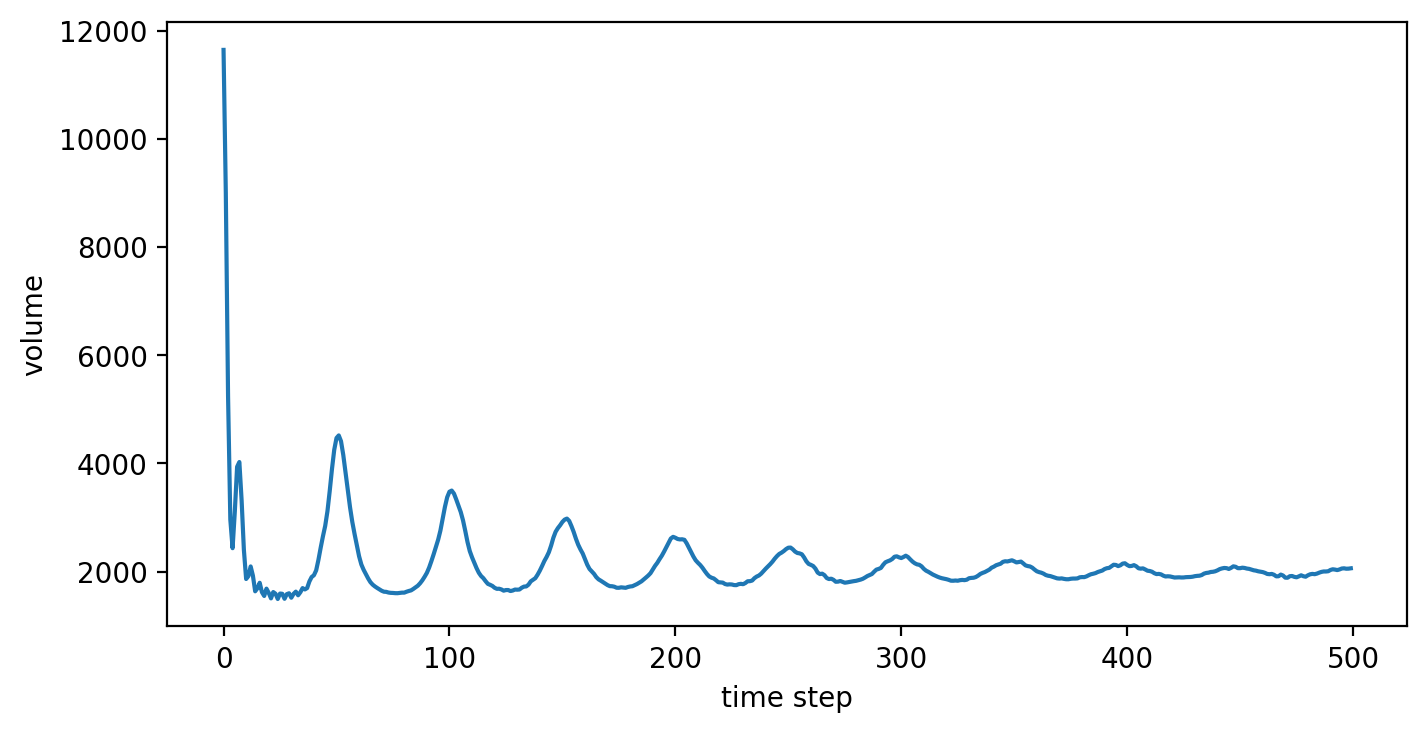

In [19]:
pyplot.figure(figsize=(8,4), dpi=200)
pyplot.plot(data[:,1])
pyplot.xlabel('time step')
pyplot.ylabel('volume')

In [20]:
# Run for 10,000 time steps
#hoomd.run(10e3)